### ISC among twins and control analyses

The goal of this notebook is to measure ISC among twins and compare it against control-twins (i.e. age- and sex-matched controls) non-twins.

The hypothesis is that ISC for twin-pairs will be generally higher than for non-twin pairs (or controls). We will further concretize the control-analyses below and in the follow-up notebooks.

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random, tqdm
from nilearn import plotting, input_data, datasets
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
from nilearn.masking import compute_brain_mask, apply_mask
from nilearn import image
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr

/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Setup variables and filenames

In [8]:
#if you want to read in precomputed results and skip the lengthy computation, 
# then uncomment this and skip the next cells
#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')
#result_df.head()
n_regions        = 293
fmri_data_file   = '../../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file = '../../data/02_rois_masks_maps/allcombined.nii'

#### Load viewer info, set up masker, load timeseries

In [9]:
twin_df = pd.read_csv('../../data/00_dataset_info/twin_df.csv')
twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

twin_df.head() #'''
print(' ')

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data  = np.swapaxes(ts_array, 0, 2)
ts_data  = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]
 
Shape of time series structure: (380, 293, 200)


In [11]:
p_val_twins  = []
p_val_others  = []

null_distributions = []

r_val_twins  = []
r_val_others = []

# Computing ISC (functional) for the real twins
n_twins         = len(twin_list)
iscs_reg_twin   = np.zeros((n_regions+1, n_twins)) #the additional line is for the anatomical similarity
#null_distributions = []

for curr_region in tqdm(range(293)):
    #print(curr_region)
    twin_iscs      = []

    #print(curr_region)
    data_roi_df = pd.DataFrame(ts_data[:,curr_region,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True, tail = 1, ci_percentile = 99)
    #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    null_distributions.append(stats_boot['null_distribution'])
    
    for twin_pair in twin_list:
        filename_1 = '../../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        curr_isc = np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1]
        twin_iscs.append(curr_isc)
 
    iscs_reg_twin[curr_region, :]   = twin_iscs #'''

    curr_mean = fisher_z_to_r(np.mean(fisher_r_to_z(twin_iscs))) 
    #print(curr_mean)
    p_val_twins.append(percentage_larger_elements(stats_boot['null_distribution'], curr_mean))
    p_val_others.append(stats_boot['p'])

    r_val_twins.append(curr_mean)
    r_val_others.append(stats_boot['isc'])


'''    fs = 8
    plt.figure(figsize=(4,2));
    #sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
    sns.histplot(stats_boot['null_distribution'] , kde=True, label='Bootstrap');
    #sns.histplot(twin_iscs , kde=True, label='true-twin-isc', color = 'orange');
    plt.xlim([0, 0.5])

    plt.ylabel('Frequency', fontsize= fs);
    plt.xlabel('ISC Values (correlation)', fontsize= fs);
    plt.title('ISC Null Distribution', fontsize= fs);
    #plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
    plt.axvline(curr_mean, linestyle='-', color='red', linewidth=2);
    plt.legend(['Bootstrap Null', 'Observed ISC'], fontsize=fs);
    
    #plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
    #plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    plt.axvline(stats_boot['ci'][0], linestyle='--', color='blue');
    plt.axvline(stats_boot['ci'][1], linestyle='--', color='blue');
    plt.show()#'''

    
#anatomical similarity
#anatomical_similarity_twins = []
#for twin_pair in tqdm(twin_list):    #this takes a while ...
#        file_a = twin_pair[0]
#        file_b = twin_pair[1] 

#        f1 = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
#        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
#        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

#        f2 = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
#        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
#        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

#        anatomical_similarity_twins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

#iscs_reg_twin[293,:] = np.asarray(anatomical_similarity_twins) #'''

print(' ')

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [02:11<00:00,  2.23it/s]

In [13]:
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
alpha = 0.05

# map isc results back to brain
isc_r_brain, isc_p_brain           = roi_to_brain(pd.Series(r_val_twins), mask_x), roi_to_brain(pd.Series(p_val_twins), mask_x)
isc_otherr_brain, isc_otherp_brain = roi_to_brain(pd.Series(r_val_others), mask_x), roi_to_brain(pd.Series(p_val_others), mask_x)
isc_diff_brain                     = roi_to_brain(pd.Series(np.asarray(r_val_twins) - np.asarray(r_val_others)), mask_x)

result_image_twins  = threshold(isc_r_brain,      isc_p_brain,      thr = fdr(isc_p_brain.data,      q = alpha)).to_nifti()
result_image_others = threshold(isc_otherr_brain, isc_otherp_brain, thr = fdr(isc_otherp_brain.data, q = alpha)).to_nifti()
result_image_diff   = threshold(isc_diff_brain,   isc_p_brain,      thr = fdr(isc_p_brain.data,      q = alpha)).to_nifti()


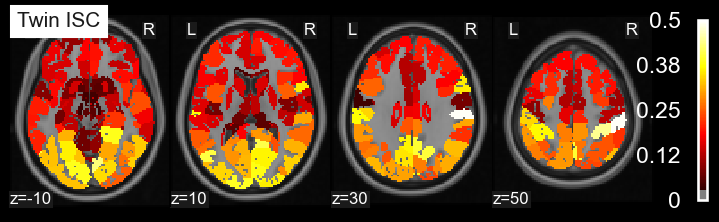

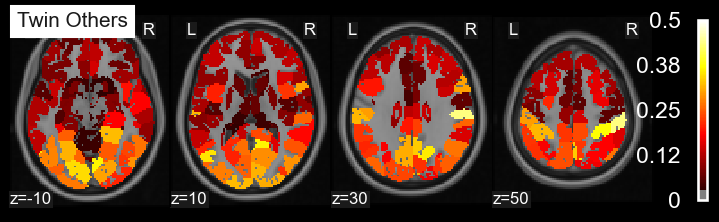

In [32]:
# visualize results
max = 0.5

fig = plt.figure(figsize=(7, 2))
nilearn.plotting.plot_stat_map(    result_image_twins, 
                                   bg_img='../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = max, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -10, 10, 30, 50],
                                   annotate     = True,
                                   title        = 'Twin ISC',
                                   figure = fig);

# visualize results
fig = plt.figure(figsize=(7, 2))
nilearn.plotting.plot_stat_map(    result_image_others, 
                                   bg_img='../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = max, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -10, 10, 30, 50],
                                   annotate     = True,
                                   title        = 'Twin Others',
                                   figure = fig);





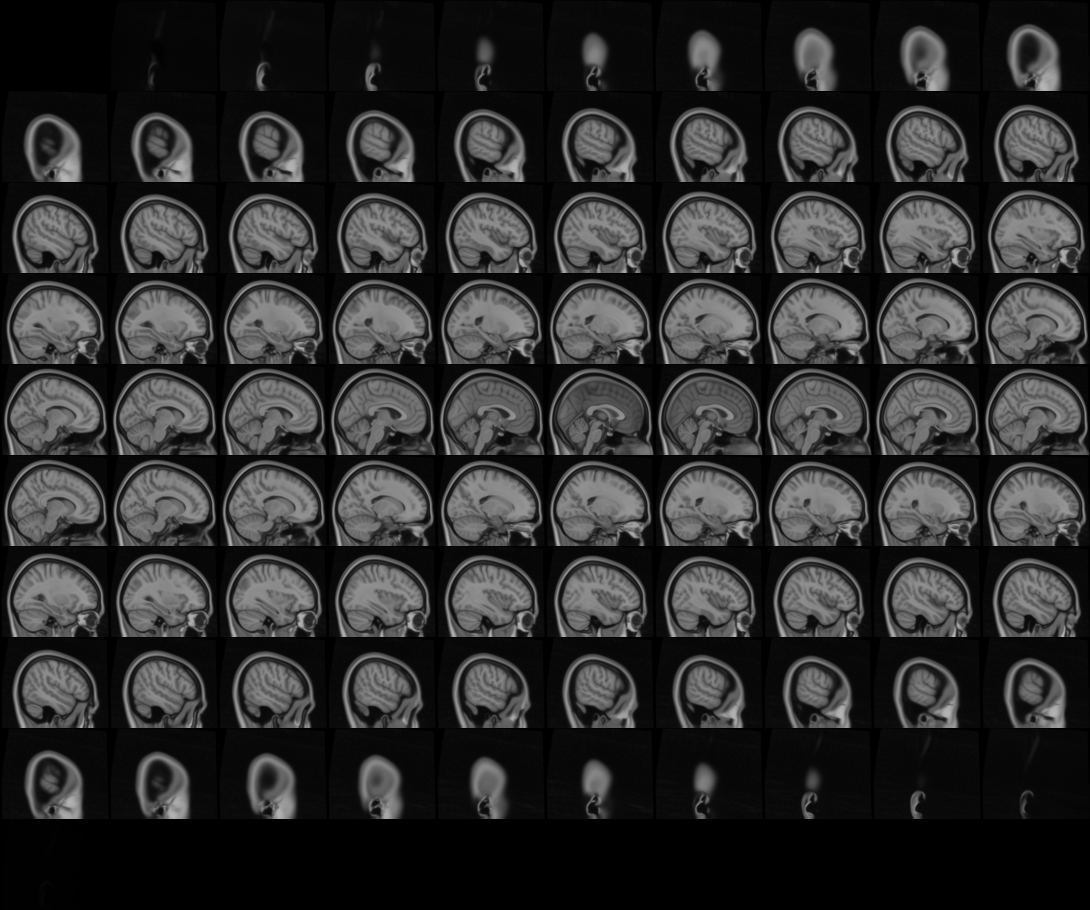
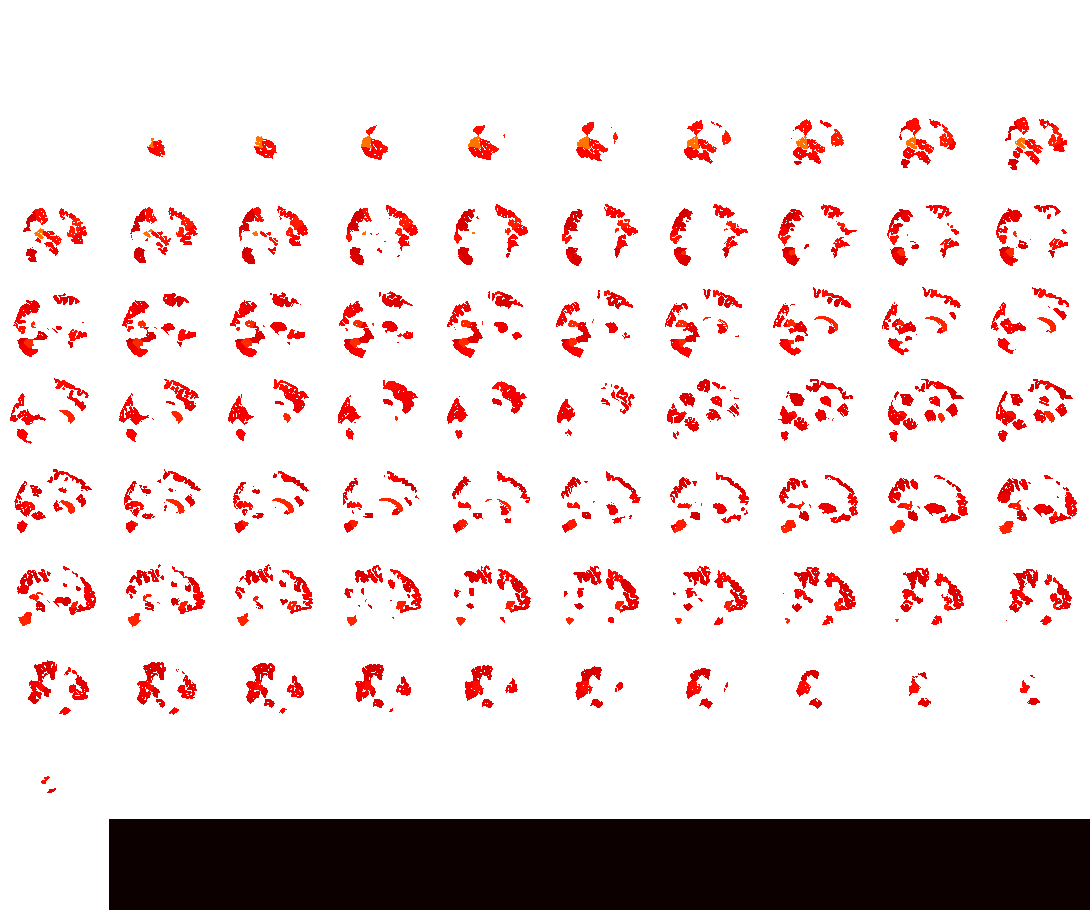

In [33]:
v = nilearn.plotting.view_img(    result_image_diff, 
                                   bg_img='../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.06,  #additional threshold for visualization
                                   vmax         = 0.2,
                                   title        = 'ISC(Twins) - ISC(Others)',);
v

In [35]:
# How many regions survive? 
p_val_twins_array = np.asarray(p_val_twins).reshape(293,1).T
print(p_val_twins_array.shape)
q                 = multipletests(p_val_twins_array[0, :], method='fdr_by')[1]
corrected         = q[np.newaxis, :] < alpha
print(len(corrected[corrected == False]))
print(corrected.shape[1] - len(corrected[corrected == False]))

(1, 293)
17
276


#### Plot ISC(Twins) vs. ISC(Others)

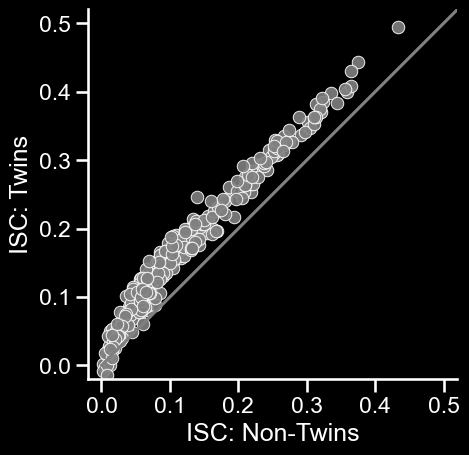

In [36]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

sns.scatterplot(x = r_val_others, 
                y = r_val_twins,
                color = 'gray', alpha = 0.9)

plt.axis('square');
plt.xlim(-0.02,.52); plt.ylim(-0.02,.52);
plt.plot([0, 1], [0, 1], color = 'gray');
plt.xticks(ticks=[0, .1, .2, .3, .4,.5]); plt.yticks(ticks=[0, .1, .2, .3 ,.4,.5])
plt.xlabel('ISC: Non-Twins'); plt.ylabel('ISC: Twins');
sns.despine()

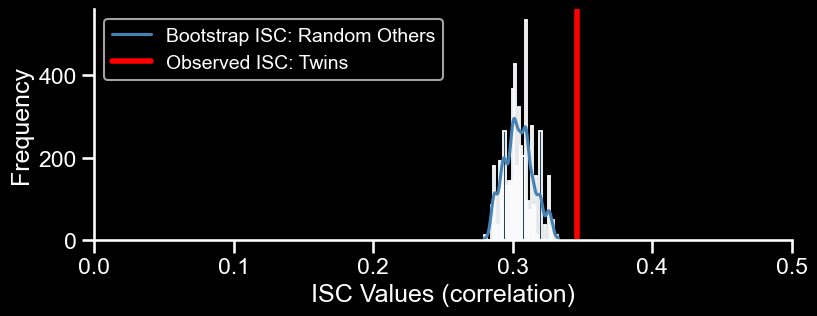

In [37]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

region_to_plot = 75
fs = 14

dist = null_distributions[region_to_plot]
twin_r = r_val_twins[region_to_plot]


plt.figure(figsize=(9,3));
sns.histplot(dist , kde=True, label='Bootstrap', color="steelblue");
plt.xlim([0, 0.5])

plt.ylabel('Frequency')# fontsize= fs);
plt.xlabel('ISC Values (correlation)')#, fontsize= fs);
plt.axvline(twin_r, linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap ISC: Random Others', 'Observed ISC: Twins'],  loc = 2, fontsize=fs),
sns.despine()    
plt.show()

#### Reading in ControlTwin-List and computing ISC among control-twins

In [19]:
#'''
controltwin_df = pd.read_csv('../../data/00_dataset_info/matched_controltwin_df.csv')

controltwin_list = controltwin_df[['twin_A_id','controltwin_B_id']].values.tolist()
print(controltwin_list[:3])

controltwin_df.head() #'''
print(' ')

[['sub-0001', 'sub-0003'], ['sub-0004', 'sub-0151'], ['sub-0005', 'sub-0043']]
 


In [21]:
#'''
# Computing ISC for the real twins
n_controltwins       = len(twin_list)
iscs_reg_controltwin = np.zeros((n_regions+1, n_controltwins))

for curr_region in tqdm(range(n_regions)):
    controltwin_iscs = []
    
    for controltwin_pair in controltwin_list:
        filename_1 = '../../data/03_extract_ts/' + controltwin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin1_data = np.load(filename_1) 
        filename_2 = '../../data/03_extract_ts/' + controltwin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin2_data = np.load(filename_2) 
        
        controltwin_iscs.append(np.corrcoef(controltwin1_data[:,curr_region], controltwin2_data[:,curr_region])[0,1])
 
    iscs_reg_controltwin[curr_region, :]   = controltwin_iscs #'''
    

#anatomical similarity
#'''
anatomical_similarity_controltwins = []
for controltwin_pair in tqdm(controltwin_list):
        file_a = controltwin_pair[0]
        file_b = controltwin_pair[1] 

        f1  = '../../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_controltwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_controltwin[293,:] = np.asarray(anatomical_similarity_controltwins) #'''
print(' ')

100%|█████████████████████████████████████████| 100/100 [16:26<00:00,  9.87s/it]

#### Computing ISC among random people

In [22]:
#'''
iscs_reg_notwin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    no_twin_iscs      = []

    for twin_pair in twin_list:
        filename_1 = '../../data/03_extract_ts/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 

        #from the remaining people, randomly chose one, excluding the actual twin
        other_twin_list = twin_df['twin_B_id'].values.tolist()
        other_people = [x for x in other_twin_list if x != twin_pair[1]]  
        no_twin_filename_1 = '../../data/03_extract_ts/' + random.choice(other_people) + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        no_twin_data1 = np.load(no_twin_filename_1) 

        no_twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], no_twin_data1[:,curr_region])[0,1])

    iscs_reg_notwin[curr_region, :] = no_twin_iscs #'''
    
    
#anatomical similarity
#'''
anatomical_similarity_notwins = []
for notwin_pair in tqdm(twin_list):
        file_a = notwin_pair[0]
        file_b = notwin_pair[1] 

        f1  = '../../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_notwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_notwin[293,:] = np.asarray(anatomical_similarity_notwins) #'''
print(' ')

100%|█████████████████████████████████████████| 100/100 [16:34<00:00,  9.94s/it]

In [23]:
# saving all that has been computed until here for future loading (bcz it takes about 50 min to re-run) 
np.savez('../../data/05_results/h2_twins_controltwins_randomothers.npz', 
         iscs_reg_twin        = iscs_reg_twin, 
         iscs_reg_controltwin = iscs_reg_controltwin,
         iscs_reg_notwin      = iscs_reg_notwin,)

# can later load again via
# data = np.load('../data/05_results/h2_twins_controltwins_randomothers.npz')
# print data['iscs_reg_controltwin']
# print data['iscs_reg_twin']
# ...


#### Compute averages and plot

In [24]:
reg_mean_twin_iscs        = np.mean(iscs_reg_twin, axis = 1)
reg_mean_controltwin_iscs = np.mean(iscs_reg_controltwin, axis = 1)
reg_mean_notwin_iscs      = np.mean(iscs_reg_notwin, axis = 1)

print(reg_mean_twin_iscs.shape)
print(reg_mean_controltwin_iscs.shape)
print(reg_mean_notwin_iscs.shape)

(294,)
(294,)
(294,)


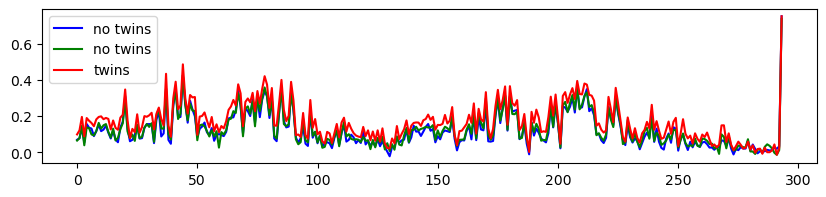

In [25]:
plt.figure(figsize = (10,2));
plt.plot(reg_mean_notwin_iscs, color = 'blue', label='no twins');
plt.plot(reg_mean_controltwin_iscs, color = 'green', label='no twins');
plt.plot(reg_mean_twin_iscs, color = 'red', label='twins');
plt.legend();

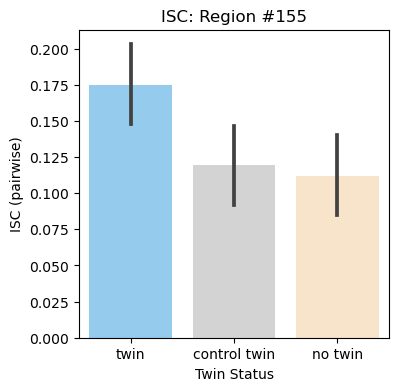

In [29]:
current_region_index = 155
#293 is anatomical_similarity


df0 = pd.DataFrame(np.vstack(( iscs_reg_notwin[current_region_index,:], 
                   len(iscs_reg_notwin[current_region_index,:]) * ['no twin'] )).T, 
                  columns = ['ISC','Twin Status'])

df1 = pd.DataFrame(np.vstack(( iscs_reg_controltwin[current_region_index,:], 
                   len(iscs_reg_controltwin[current_region_index,:]) * ['control twin'] )).T, 
                   columns = ['ISC','Twin Status'])

df2 = pd.DataFrame(np.vstack(( iscs_reg_twin[current_region_index,:], 
                   len(iscs_reg_twin[current_region_index,:]) * ['twin'] )).T, 
                   columns = ['ISC','Twin Status'])

result_df = pd.concat([df2, df1, df0])
del df1, df2, df0


result_df['ISC'] = result_df['ISC'].astype('float')

#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')


plt.figure(figsize =  (4,4))
sns.barplot(data=result_df, 
            x="Twin Status", 
            y="ISC",
            palette = [ 'lightskyblue','lightgrey','bisque']).set(title='ISC: Region #' + str(current_region_index));
#plt.ylim([0.6, 0.8])
plt.ylabel('ISC (pairwise)');

In [13]:
#result_df.to_csv('../data/05_results/twin_isc_df.csv')

In [31]:
#result_df

# 
So, up to here we have shown that 

- at least nominally, ISC among twins is stronger than among non-twins.
- from first glance, it appears that this is a relatively global effect, i.e. ISC seems consistently elevated throughout the brain, not just in a single region.
- tentative interpretation: it could be a general 'attentional' effect.
- seeing the world in the same way? 


Next steps: 
- run statistics
- examine if some regions stand out
- examine e.g. if this is demonstrable for all age groups.
- examine if this could be explained e.g. by anatomical differences ...



In [33]:
#diffs[:292].shape

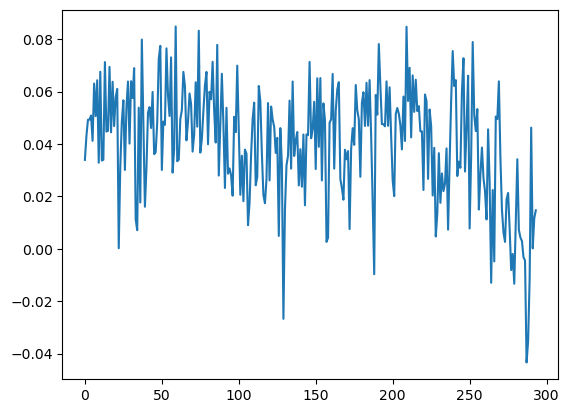

In [34]:
diffs = reg_mean_twin_iscs - reg_mean_controltwin_iscs
plt.plot(diffs);

from nilearn import input_data, datasets
all293_rois_file       = '../../data/02_rois_masks_maps/allcombined.nii'
all293_masker = input_data.NiftiLabelsMasker(all293_rois_file, 
                                             detrend     = True, 
                                             standardize = True,
                                             high_pass   = 0.01, 
                                             t_r         = 0.8, 
                                             low_pass    = 0.12 );
all293_masker.fit('../../data/02_rois_masks_maps/sub-0001_ses-02_task-partlycloudy_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
brainisc = all293_masker.inverse_transform(np.reshape(diffs[:293], (1,293))) #drop last element because that's just anatomy


<Figure size 1000x600 with 0 Axes>

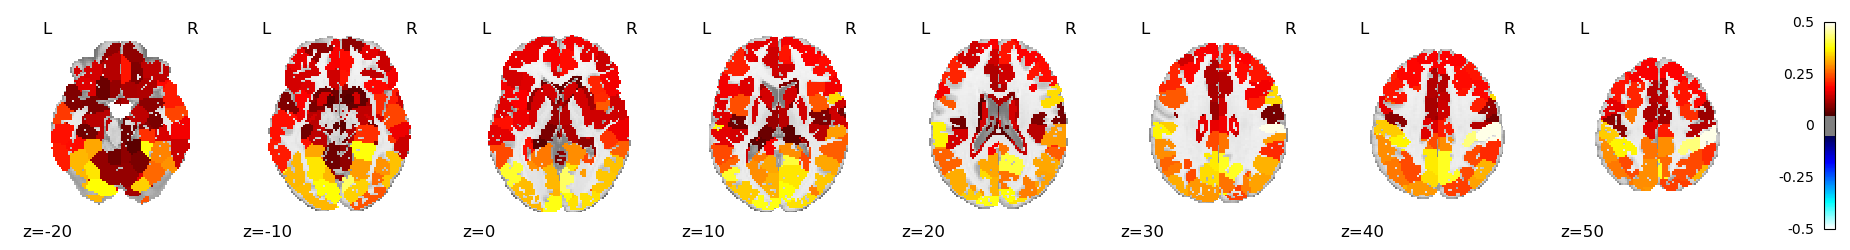

<Figure size 1000x600 with 0 Axes>

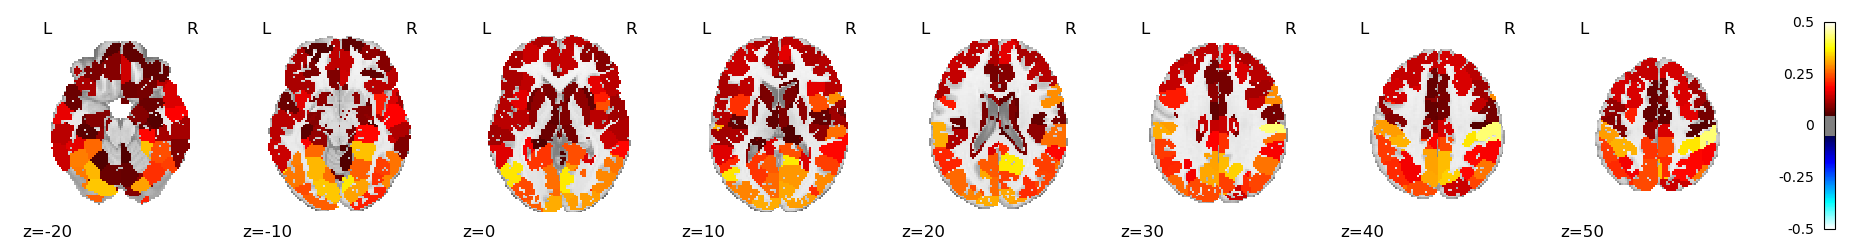

<Figure size 1000x600 with 0 Axes>

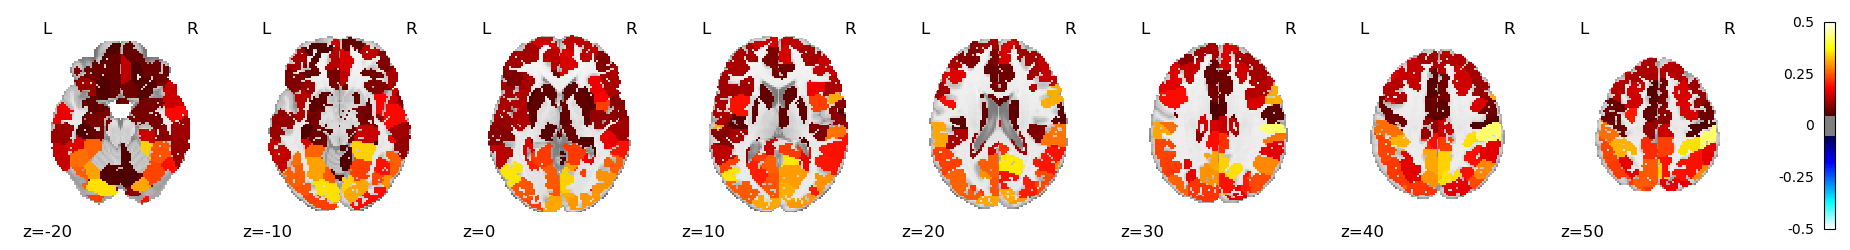

In [35]:
curr_isc = np.reshape(reg_mean_twin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


curr_isc = np.reshape(reg_mean_controltwin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


curr_isc = np.reshape(reg_mean_notwin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


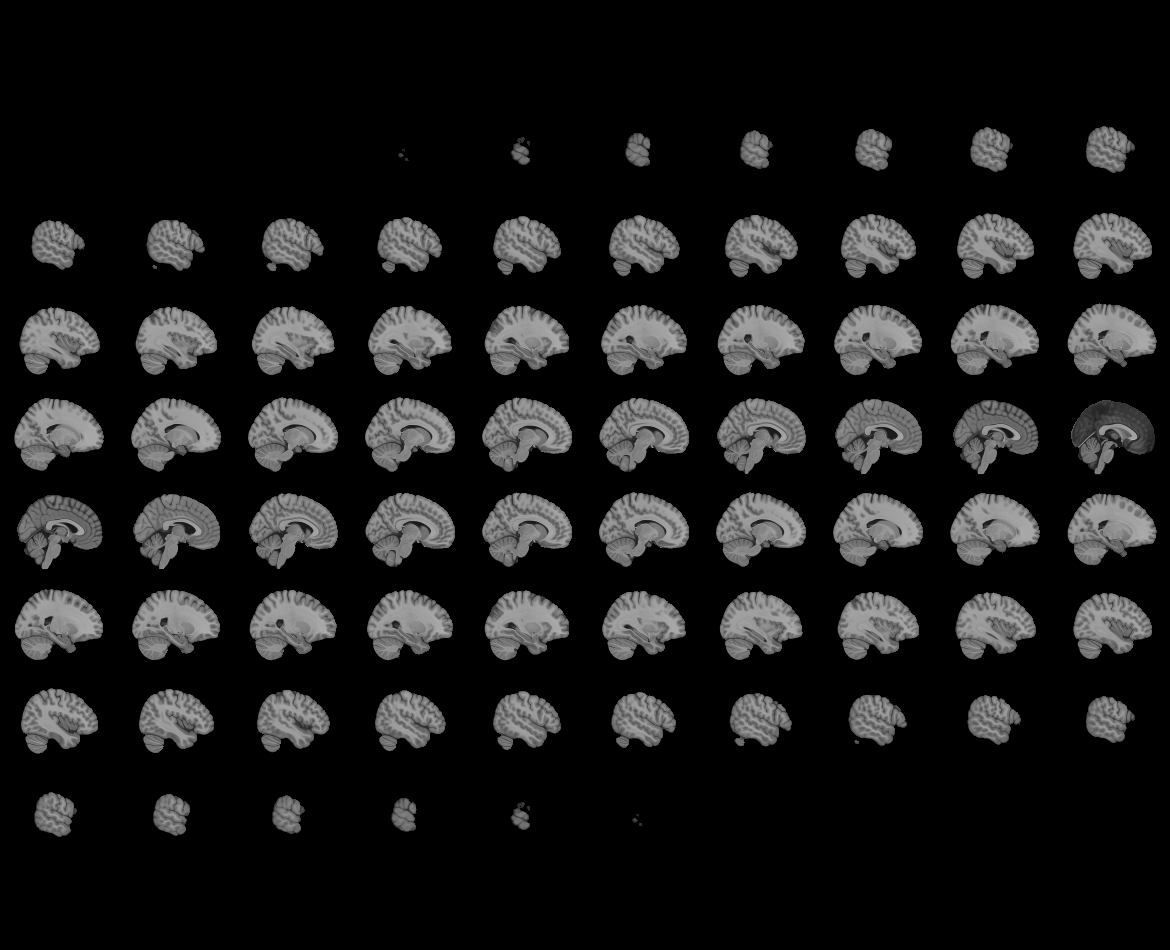
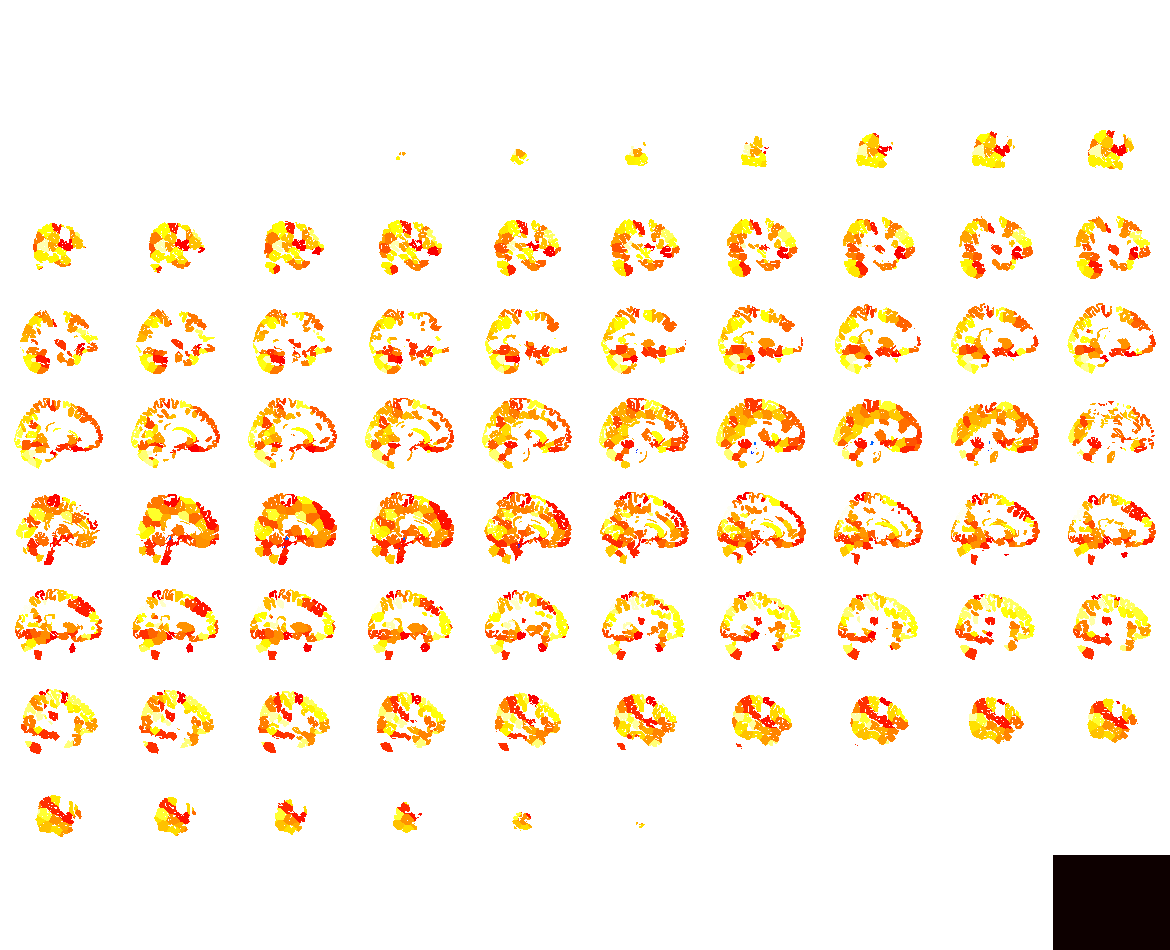

In [36]:
import nilearn.plotting
view = nilearn.plotting.view_img(brainisc, threshold = 0.03)
view

In [38]:
df = pd.DataFrame([reg_mean_twin_iscs[:293], reg_mean_controltwin_iscs[:293], reg_mean_notwin_iscs[:293]]).T
df.columns = ['twins', 'control_twins', 'no_twins']
df

,twins,control_twins,no_twins
0,0.098785,0.064853,0.069230
1,0.121026,0.077913,0.077583
2,0.195469,0.146196,0.134432
3,0.088225,0.038925,0.054493
4,0.189220,0.138337,0.156199
...,...,...,...
288,0.000556,0.035886,0.010108
289,0.010104,0.021556,0.012303
290,0.043552,-0.002692,0.026762
291,-0.013512,-0.013670,0.019348


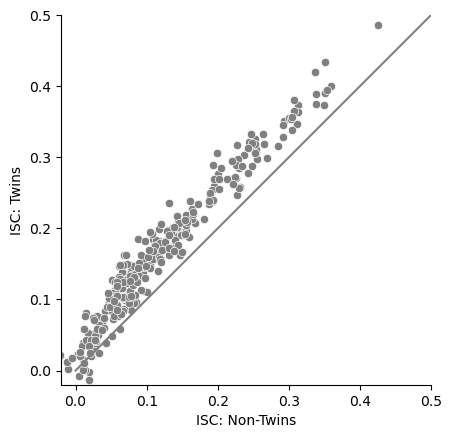

In [40]:
sns.scatterplot(x = df['no_twins'].values, 
                y = df['twins'].values,
                color = 'gray')
plt.axis('square');
plt.xlim(-0.02,.5);
plt.ylim(-0.02,.5);

plt.plot([0, 1], [0, 1], color = 'gray')

plt.xticks(ticks=[0, .1, .2, .3, .4,.5])
plt.yticks(ticks=[0, .1, .2, .3 ,.4,.5])

plt.xlabel('ISC: Non-Twins')
plt.ylabel('ISC: Twins')
sns.despine()

<Axes: >

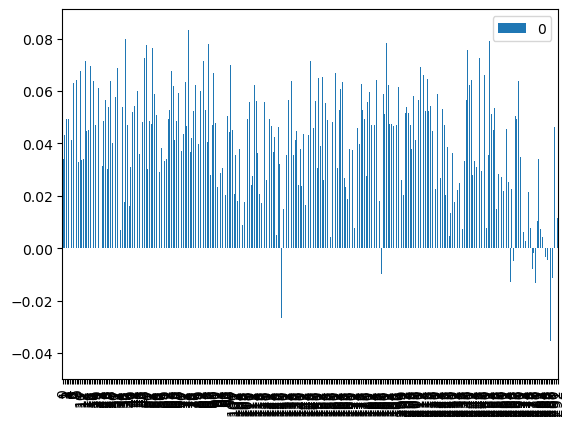

In [41]:
df1 =  pd.DataFrame(df['twins'] - df['control_twins'])
df1.plot(kind="bar")

10


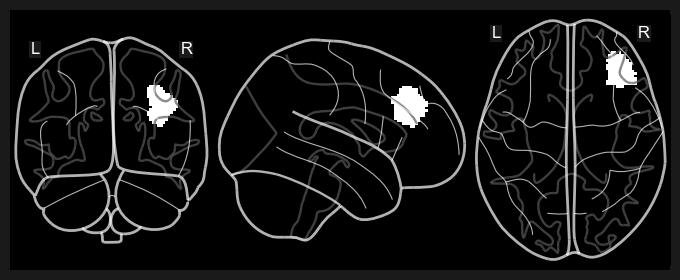

In [197]:
from nilearn import plotting, maskers, datasets

rois_file              = '../../data/02_rois_masks_maps/shen_2mm_268_parcellation.nii'
masker_prefitting_file = '../../data/02_rois_masks_maps/maskerprefit_bold.nii.gz'

my_masker            = maskers.NiftiLabelsMasker(rois_file);
my_masker.fit(masker_prefitting_file);


roi_list = [47, 48, 49, 75, 80]
roi_list = [10]

for my_roi in roi_list:
    print(my_roi)
    vec = np.zeros(268)
    vec[my_roi] = 1
    curr_vec = np.reshape(vec, (268,1)).T
    curr_img = my_masker.inverse_transform(curr_vec);
    
    nilearn.plotting.plot_glass_brain(curr_img, black_bg=True,)
    plt.show()